## Imports

In [1]:
import pandas as pd
import numpy as np
import ultraplot as pplt

import os

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from shapely.geometry import Polygon

## Global Settings

In [2]:
REGIONS = [
    {
        "name": "Beaufort Gyre",
        "color": "red",
        "lon_min": -180,
        "lon_max": -130,
        "lat_min": 72,
        "lat_max": 80,
        "text_lon_offset": -10,
        "text_lat_offset": 7
    }, 
    {
        "name": "Fram Strait",
        "color": "blue",
        "lon_min": -15,
        "lon_max": 12,
        "lat_min": 76,
        "lat_max": 81,
        "text_lon_offset": 0,
        "text_lat_offset": 4
    }
]

MAP_PROJ = ccrs.NorthPolarStereo()
DATA_PROJ = ccrs.PlateCarree()

## Mapping

In [3]:
def curved_box(lon_min, lon_max, lat_min, lat_max, points=100, box_delta=0.5):
    # top and bottom edges
    lon_min -= box_delta
    lon_max += box_delta
    lat_min -= box_delta
    lat_max += box_delta
    top = np.column_stack([np.linspace(lon_min, lon_max, points),
                           lat_max + 2*np.sin(np.linspace(0, np.pi, points))/10])
    bottom = np.column_stack([np.linspace(lon_max, lon_min, points),
                              lat_min + 2*np.sin(np.linspace(0, np.pi, points))/10])
    left = np.column_stack([np.full(points, lon_min),
                            np.linspace(lat_max, lat_min, points)])
    right = np.column_stack([np.full(points, lon_max),
                             np.linspace(lat_min, lat_max, points)])
    coords = np.vstack([top, right, bottom, left])
    return Polygon(coords)

In [4]:
def draw_map(ax, proj):
    # Add base features
    for region in REGIONS:
        ax.coastlines(resolution='50m')
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.OCEAN, facecolor='aliceblue')
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        poly = curved_box(region['lon_min'], region['lon_max'],
                          region['lat_min'], region['lat_max'])
        feature = ShapelyFeature([poly], proj,
                                 edgecolor=region['color'], 
                                 facecolor='none', linewidth=2)
        ax.add_feature(feature)

        # Add label
        ax.text(
            (region["lon_min"] + region["lon_max"]) / 2 + region["text_lon_offset"],
            (region["lat_min"] + region["lat_max"]) / 2 + region["text_lat_offset"],
            region['name'],
            transform=proj,
            ha='center',
            va='bottom',
            color=region['color'],
            fontsize=9
        )

## Plot Buoys

In [5]:
# Function to filter observations in a region
def filter_region(df, region):
    return df[
        (df['Lon'] >= region['lon_min']) &
        (df['Lon'] <= region['lon_max']) &
        (df['Lat'] >= region['lat_min']) &
        (df['Lat'] <= region['lat_max'])
    ].copy()

In [7]:
# Plot buoys
test_df = pd.read_csv("../../data/L1_DATA/2007.csv")

# Filter for each region and add a column with region name
filtered_dfs = []
for region in REGIONS:
    temp = filter_region(test_df, region)
    temp['Region'] = region['name']
    filtered_dfs.append(temp)

# Combine all filtered observations
df_filtered = pd.concat(filtered_dfs, ignore_index=True)

## Mapping

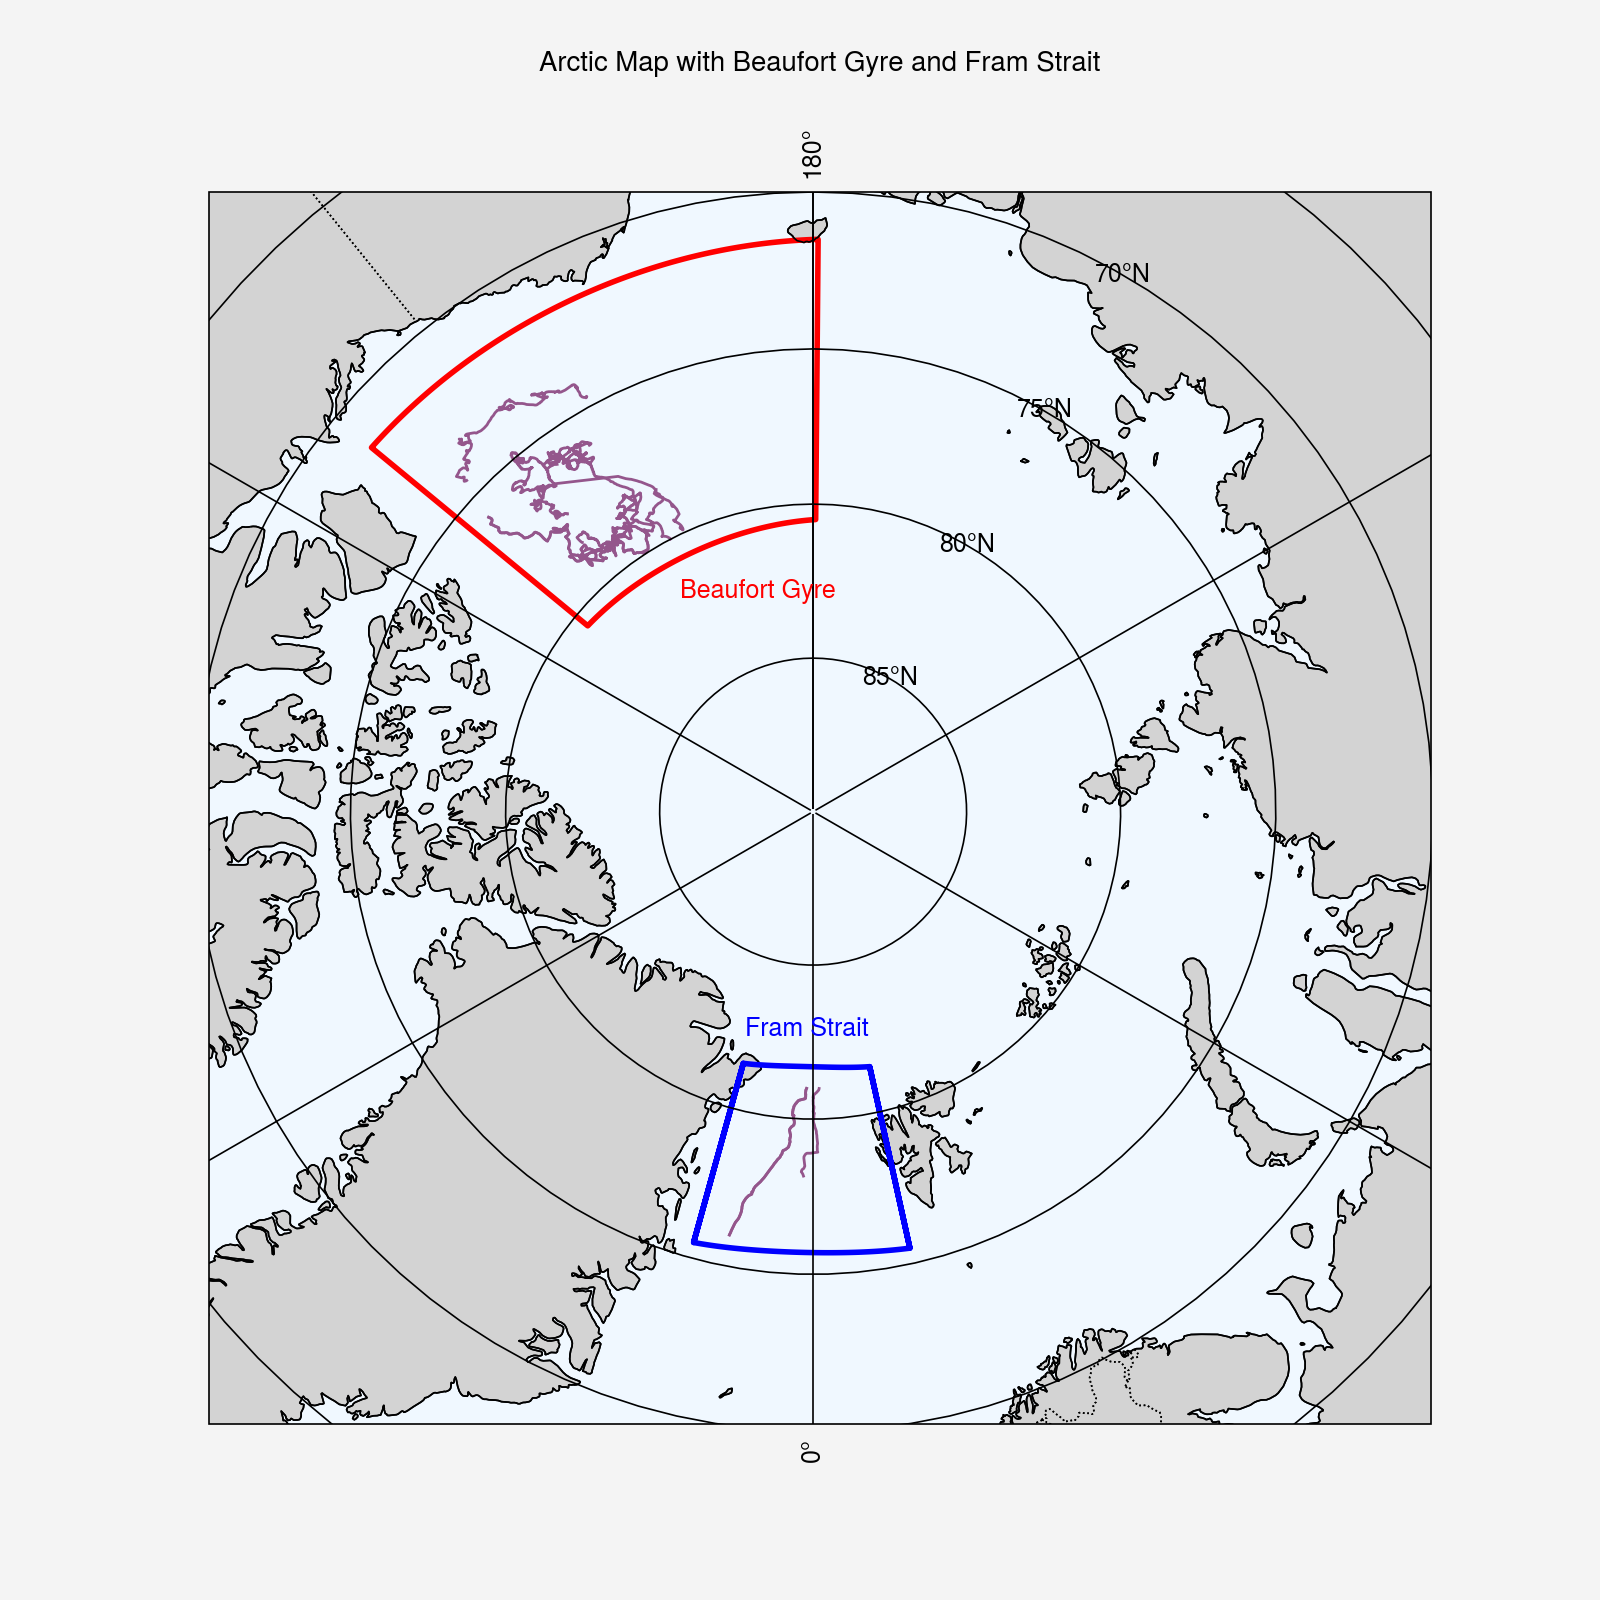

In [9]:
# Create the map
fig = plt.figure(figsize=(8, 8))

ax = plt.axes(projection=MAP_PROJ)
ax.set_extent([-180, 180, 70, 90], crs=DATA_PROJ)

draw_map(ax, DATA_PROJ)

for buoy_id, buoy_data in list(df_filtered.groupby("BuoyID")):
    buoy_data = buoy_data.sort_values(by=["Year","Month","Day","Hour",
                                          "Min" if "Min" in buoy_data else "Minute",
                                          "Sec" if "Sec" in buoy_data else "Second"])
    
    ax.plot((buoy_data["Lon"] + 180)%360-180, buoy_data['Lat'], transform=DATA_PROJ,
            color='purple', marker='o', linewidth=1, markersize=0)

# Add gridlines
gl = ax.gridlines(draw_labels=True)

plt.title("Arctic Map with Beaufort Gyre and Fram Strait", pad=20)
plt.show()